# VacationPy
----

#### Note
* Keep an eye on your API usage. Use https://developers.google.com/maps/reporting/gmp-reporting as reference for how to monitor your usage and billing.

* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [163]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import gmaps
import os
from pprint import pprint
from IPython.display import Image 

# Import API key
from api_keys import g_key

### Store Part I results into DataFrame
* Load the csv exported in Part I to a DataFrame

In [164]:
cities_df = pd.read_csv('test.csv')
cities_df.head()

,ran_lat,ran_lng,Name,Country Code,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),lat,lng
0,-69.290178,139.634768,hobart,au,53.60,87.0,90.0,5.82,-42.88,147.33
1,-46.693868,-36.697486,chuy,uy,55.08,59.0,69.0,13.44,-33.70,-53.46
2,-31.114970,12.965113,oranjemund,na,61.83,66.0,0.0,13.09,-28.55,16.43
3,64.644748,-77.657177,iqaluit,ca,32.00,94.0,90.0,4.70,63.75,-68.51
4,29.896238,73.855092,ganganagar,in,86.65,14.0,0.0,3.87,29.92,73.88


### Humidity Heatmap
* Configure gmaps.
* Use the Lat and Lng as locations and Humidity as the weight.
* Add Heatmap layer to map.

In [165]:
gmaps.configure(api_key=g_key)

# Create a poverty Heatmap layer
fig = gmaps.figure(center=(0, 20), zoom_level=2)

loc = cities_df[["lat", "lng"]]
humidity = cities_df['Humidity (%)']

data = cities_df[['lat', 'lng', 'Humidity (%)']]
heat_layer = gmaps.heatmap_layer(loc, weights=humidity, 
                                 dissipating=False, max_intensity=200,
                                 point_radius = 5)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

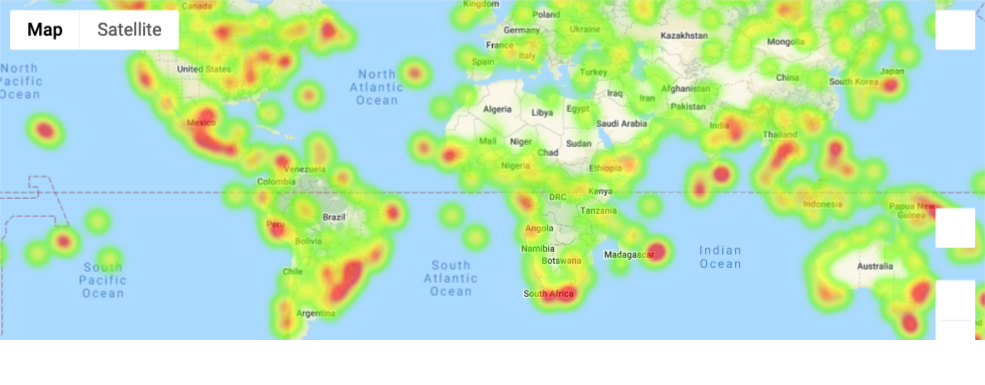

In [166]:
Image(filename='images/heatmap.png', width=900, height=500)

### Create new DataFrame fitting weather criteria
* Narrow down the cities to fit weather conditions.
* Drop any rows will null values.

In [167]:
preferred_df = cities_df.loc[(cities_df['Wind Speed (mph)'] < 10) & (cities_df['Temperature (F)'] < 80) &
                 (cities_df['Temperature (F)'] > 70) & (cities_df['Cloudiness (%)'] == 0)].reset_index(drop=True)
preferred_df

,ran_lat,ran_lng,Name,Country Code,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph),lat,lng
0,17.673865,-128.286507,guerrero negro,mx,77.41,55.0,0.0,4.79,27.98,-114.06
1,22.692839,-124.015264,san quintin,mx,77.31,47.0,0.0,1.79,30.48,-115.95
2,25.200718,-98.339612,san fernando,mx,78.04,66.0,0.0,4.12,24.85,-98.15
3,27.000477,-101.957000,nadadores,mx,75.00,44.0,0.0,3.00,27.05,-101.60
4,36.899402,60.852358,sarakhs,ir,73.40,23.0,0.0,6.93,36.54,61.16
5,-28.447921,22.653073,kathu,za,73.00,13.0,0.0,1.01,-27.70,23.05
6,33.631280,73.493861,kahuta,pk,78.01,64.0,0.0,5.32,33.59,73.39


### Hotel Map
* Store into variable named `hotel_df`.
* Add a "Hotel Name" column to the DataFrame.
* Set parameters to search for hotels with 5000 meters.
* Hit the Google Places API for each city's coordinates.
* Store the first Hotel result into the DataFrame.
* Plot markers on top of the heatmap.

In [168]:
hotel_df = preferred_df[['Name', 'Country Code', 'lat', 'lng']]
hotel_df

,Name,Country Code,lat,lng
0,guerrero negro,mx,27.98,-114.06
1,san quintin,mx,30.48,-115.95
2,san fernando,mx,24.85,-98.15
3,nadadores,mx,27.05,-101.60
4,sarakhs,ir,36.54,61.16
5,kathu,za,-27.70,23.05
6,kahuta,pk,33.59,73.39


In [171]:
hotel_df['Hotel Name'] = ''
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
params = {
#     "rankby": "distance",
    "radius": 5000,
    "type": "lodging",
    "key": g_key,
}

for index, row in preferred_df.iterrows():
    lat = row['lat']
    lng = row['lng']
    params["location"]= f'{lat},{lng}'
    
    try:
        response = requests.get(base_url, params=params).json()
        hotel_df.loc[index, 'Hotel Name'] = response['results'][0]['name']
    except:
        print('error')


/Users/ange/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ange/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [172]:
hotel_df

,Name,Country Code,lat,lng,Hotel Name
0,guerrero negro,mx,27.98,-114.06,"Casa Laguna, Bed & Breakfast"
1,san quintin,mx,30.48,-115.95,Old Mill Hotel
2,san fernando,mx,24.85,-98.15,Casa De Huespedes Eulogio
3,nadadores,mx,27.05,-101.60,La Cabañita - Eventos
4,sarakhs,ir,36.54,61.16,Sarakhs Abrisham Hotel
5,kathu,za,-27.70,23.05,Carlandre
6,kahuta,pk,33.59,73.39,Fazal shah bhukhari


In [173]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Hotel Name</dt><dd>{Hotel Name}</dd>
<dt>City</dt><dd>{Name}</dd>
<dt>Country</dt><dd>{Country Code}</dd>
</dl>
"""
# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
hotel_info = [info_box_template.format(**row) for index, row in hotel_df.iterrows()]
locations = hotel_df[["lat", "lng"]]

In [174]:
# Add marker layer ontop of heat map
fig = gmaps.figure(center=(0, 0), zoom_level=2)
markers = gmaps.marker_layer(locations, info_box_content=hotel_info)

# Display figure
fig.add_layer(markers)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

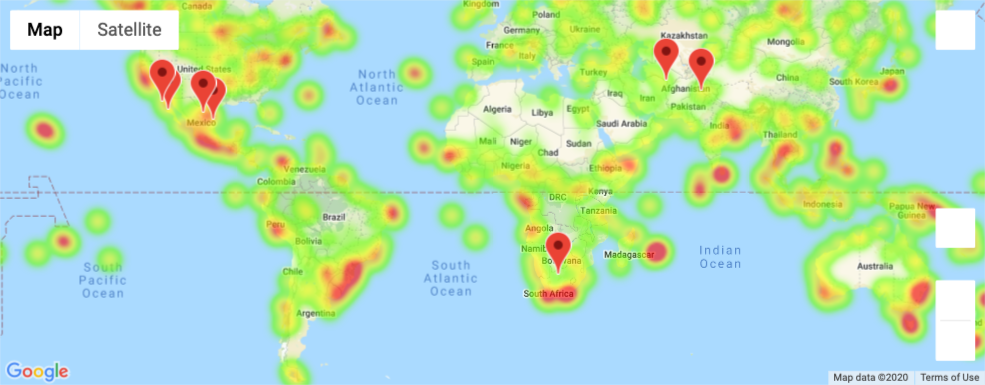

In [175]:
Image(filename='images/hotelmap.png', width=900, height=500)